In [ ]:
# Standard libraries
import os
import sys
import errno
import random
import gzip
import pickle

# Numerical and data handling
import numpy as np
import pandas as pd

# Sparse matrices and spatial operations
from scipy.sparse import csr_matrix, lil_matrix
from scipy.spatial import KDTree, ConvexHull  # KDTree for spatial queries, ConvexHull for convex hull processing
from scipy.spatial.distance import pdist, squareform
from scipy import ndimage, stats
from scipy.signal import convolve2d

# Machine learning and clustering
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import LabelEncoder

# Image processing and similarity metrics
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error

# Plotting and visualization
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
from matplotlib.ticker import EngFormatter

# Data visualization settings
sns.set_theme(style="whitegrid")
fruitpunch = sns.blend_palette(['white', 'red'], as_cmap=True)

# Parallel processing
from multiprocessing import Pool
from functools import partial
import concurrent.futures

# Progress tracking
import tqdm

# Hi-C data processing
import cooler

sys.path.append('/share/home/mliu/shareb/mliu/HiMulti/3-sprite/CHARMtools')
from CHARMtools import Cell3Ddev as Cell3D
from CHARMtools import MultiCell3D


In [42]:
def flatten(nested_list):
    flattened = []
    for element in nested_list:
        if isinstance(element, list):
            flattened.extend(flatten(element))  # 递归调用flatten
        else:
            flattened.append(element)
    return flattened

def point_cloud_rotation(point_cloud, x_angle=None,y_angle=None,z_angle=None):
    if x_angle:
        rotation_matrix = np.array([[1,0,0],[0,np.cos(x_angle),-np.sin(x_angle)],[0,np.sin(x_angle),np.cos(x_angle)]])
        point_cloud = np.dot(point_cloud,rotation_matrix)
    if y_angle:
        rotation_matrix = np.array([[np.cos(y_angle),0,np.sin(y_angle)],[0,1,0],[-np.sin(y_angle),0,np.cos(y_angle)]])
        point_cloud = np.dot(point_cloud,rotation_matrix)
    if z_angle:
        rotation_matrix = np.array([[np.cos(z_angle),-np.sin(z_angle),0],[np.sin(z_angle),np.cos(z_angle),0],[0,0,1]])
        point_cloud = np.dot(point_cloud,rotation_matrix)

    return point_cloud

def plot_metrics(x, xlabel, pearson, spearman, ssmi, rms, title, color):
    # line plot of corrs, ssmis, and rms vs width
    fig, axes = plt.subplots(1, 4, figsize=(10, 3), dpi=120)

    for ax in axes:
        # 去除右边框和上边框
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        # 不显示网格
        ax.grid(False)
    
    axes[0].plot(x, pearson, color=color)
    axes[0].set_xlabel(xlabel)
    axes[0].set_ylabel('Pearson')
    axes[0].set_title('Pearson')

    axes[1].plot(x, spearman, color=color)
    axes[1].set_xlabel(xlabel)
    axes[1].set_ylabel('Spearman')
    axes[1].set_title('Spearman')

    axes[2].plot(x, ssmi, color=color)
    axes[2].set_xlabel(xlabel)
    axes[2].set_ylabel('SSIM')
    axes[2].set_title('SSIM')

    axes[3].plot(x, rms, color=color)
    axes[3].set_xlabel(xlabel)
    axes[3].set_ylabel('SSC')
    axes[3].set_title('SSC')

    plt.tight_layout()
    plt.savefig(f"{title}.png")
    
bp_formatter = EngFormatter('b')

def format_ticks(ax, x=True, y=True, rotate=True):
    if y:
        ax.yaxis.set_major_formatter(bp_formatter)
    if x:
        ax.xaxis.set_major_formatter(bp_formatter)
        ax.xaxis.tick_bottom()
    if rotate:
        ax.tick_params(axis='x',rotation=45)
        

def plot_matrix(matrix, title, region_start, region_end, cmap, vmax, vmin):
    plt.figure(figsize=(4, 4), facecolor='white')
    plt.imshow(matrix,
               extent=(region_start, region_end, region_end, region_start),
               interpolation='none', vmin=vmin, vmax=vmax, cmap=cmap)

    plt.title(title)
    # 不显示网格
    plt.grid(False)
    ax = plt.gca()

    ax.yaxis.set_ticks_position('left')  # 设置y轴刻度仅在左侧显示
    ax.xaxis.set_ticks_position('none')  # 禁用x轴底部刻度显示
    ax.set_xticks([])  # 移除x轴的所有刻度
    ax.set_xticklabels([])  # 移除x轴的刻度标签

    ax.set_yticks([region_start, region_end])  # 仅设置最小值和最大值作为刻度
    ax.set_yticklabels([str(region_start), str(region_end)])  # 设置刻度标签


    format_ticks(ax)

    # 显示 colorbar
    cbar = plt.colorbar(shrink=0.8)
    cbar.set_label(title)
    cbar.set_ticks([vmin,vmax])
    cbar.set_ticklabels([vmin,vmax])

    plt.show()

def plot_single_matrix(matrix,cmap="fall",title=None,vmax=1,vmin=0):
    plt.figure(figsize=(8, 3),dpi=120)
    plt.subplot(1, 2, 1)
    plt.imshow(matrix, cmap=cmap,vmax=vmax,vmin=vmin)
    plt.colorbar(label=title)
    plt.title(title)

    
def normalize_gam_matrix(gam_matrix, mean_slices):
    # 定义标准化后的矩阵
    normalized_matrix = np.zeros_like(gam_matrix)
    # 获取矩阵的行数和列数
    rows, cols = gam_matrix.shape
    # 遍历矩阵中的每个元素
    for i in range(rows):
        for j in range(cols):
            # 提取当前元素
            D = gam_matrix[i, j]
            # 计算 f_a 和 f_b
            f_a = mean_slices[i]
            f_b = mean_slices[j]

            # 应用标准化规则
            if D < 0:
                normalized_matrix[i, j] = min(f_a * f_b, (1 - f_a) * (1 - f_b))
            else:
                normalized_matrix[i, j] = min(f_b * (1 - f_a), f_a * (1 - f_b))

    return normalized_matrix

def generate_spheres(tdg_path, CpG_df, radius, sphere_num):
    tdg = pd.read_csv(tdg_path,sep="\t",header = None)
    tdg.columns = ["chrom","start","x","y","z"]
    tdg["start"] = tdg["start"].astype(int)
    tdg["pos"] = tdg["start"] + 20000

    spheres = []
    for _ in range(sphere_num):

        # Randomly rotate the point cloud
        rotated = point_cloud_rotation(tdg[["x", "y", "z"]].values,
                                       x_angle=np.random.uniform(0, 2*np.pi),
                                       y_angle=np.random.uniform(0, 2*np.pi),
                                       z_angle=np.random.uniform(0, 2*np.pi))

        tdg_temp = tdg[["chrom", "pos"]]
        tdg_temp = tdg_temp.assign(x=rotated[:, 0], y=rotated[:, 1], z=rotated[:, 2])

        # Generate a random center point for the sphere
        x_center = np.random.uniform(tdg_temp["x"].min(), tdg_temp["x"].max())
        y_center = np.random.uniform(tdg_temp["y"].min(), tdg_temp["y"].max())
        z_center = np.random.uniform(tdg_temp["z"].min(), tdg_temp["z"].max())

        # Determine which bins are within the radius of the sphere
        tdg_temp["distance"] = np.sqrt((tdg_temp["x"] - x_center) ** 2 + 
                                       (tdg_temp["y"] - y_center) ** 2 + 
                                       (tdg_temp["z"] - z_center) ** 2)
        
        sphere = tdg_temp.query('distance <= @radius').assign(insphere=lambda x: 1)[["chrom", "pos", "insphere"]]

        # Merge with CpG_df
        sphere = pd.merge(CpG_df, sphere, how="left").fillna(0)
        spheres.append(sphere["insphere"].values)

    return spheres




def generate_spheres_size(tdg_path, radius_mean, radius_std, sphere_num, target_chr):
    tdg = pd.read_csv(tdg_path, sep="\t", header=None)
    tdg.columns = ["chrom", "start", "x", "y", "z"]
    
    tdg["start"] = tdg["start"].astype(int)
    tdg["pos"] = tdg["start"] + 20000
    point_cloud = tdg[["x", "y", "z"]].values

    kd_tree = KDTree(point_cloud)
    centers = point_cloud[np.random.choice(point_cloud.shape[0], sphere_num, replace=False)]
    
    chr_point_sphere = pd.DataFrame(columns=["chrom", "start"])
    cluster_size_list = []
    
    for center in centers:
        radius = np.random.normal(radius_mean, radius_std)
        if radius <= 0:
            continue
        
        indices = kd_tree.query_ball_point(center, radius)
        hole_points = tdg.iloc[indices][["chrom", "start"]]
        cluster_size_list.append(len(hole_points))

        hole_points_chr = hole_points[hole_points["chrom"] == target_chr]
        chr_point_sphere = pd.concat([chr_point_sphere, hole_points_chr], axis=0)

    return chr_point_sphere, cluster_size_list




def process_results(results, df_bin_mm9_40kb, contact_matrix):
    matrix_size = contact_matrix.shape[0]
    #遍历所有细胞
    for result in results:
        cluster_result, cluster_size = result  

        # print(len(cluster_result)) #是切片的个数
        #遍历每个切片
        for points,size in zip(cluster_result,cluster_size):
            if points.shape[0]>0:
                print(f"size is {size}")
                weight = 2 / size
                for i in range(points.shape[0]):
                    for j in range(i+1,points.shape[0]):
                        pos1 = points[i][1]
                        pos2 = points[j][1]
                        bin1 = pos1 // 40000
                        bin2 = pos2 // 40000
                        contact_matrix[bin1, bin2] += weight
    nonzero_count = np.count_nonzero(contact_matrix)
    print(f"******************nonzero_count is {nonzero_count}")

    return contact_matrix


from typing import Union
from contextlib import suppress

def meanFilter(a: np.ndarray, h: int):
   
    # Create a filter kernel (2h+1 by 2h+1) with all ones
    fSize = 2 * h + 1
    kernel = np.ones((fSize, fSize)) / (fSize * fSize)  # Normalized kernel for mean filter

    # Apply convolution to the input matrix
    filtered = convolve(a, kernel, mode='constant', cval=0.0)
    return filtered


def trimDiags(a: np.ndarray, iDiagMax: int, bKeepMain: bool):
    rows, cols = np.indices(a.shape)
    gDist = np.abs(rows - cols)
    mask = (gDist < iDiagMax) & (bKeepMain | (gDist != 0))
    result = np.where(mask, a, 0)
    
    return result


epsilon = 1e-10
def sccByDiag(m1: np.ndarray, m2: np.ndarray, nDiags: int):
    rho_list = []
    weight_list = []

    for diag in range(nDiags):
        # Extract the diagonal elements with offset 'diag'
        m1_diag = np.diag(m1, k=diag)
        m2_diag = np.diag(m2, k=diag)

        # Remove common zero entries
        mask = ((np.abs(m1_diag) > epsilon) | (np.abs(m2_diag) > epsilon)) & ~np.isnan(m1_diag) & ~np.isnan(m2_diag)


        m1_diag_nonzero = m1_diag[mask]
        m2_diag_nonzero = m2_diag[mask]
       

        # If there are fewer than 3 non-zero values, skip this diagonal
        if len(m1_diag_nonzero) < 3:
            continue

        # Compute Pearson correlation for the diagonal
        rho = np.corrcoef(m1_diag_nonzero, m2_diag_nonzero)[0, 1]
        if np.isnan(rho):
            rho = 0  # Handle NaN values

        # Compute the weight based on the number of non-zero samples
        num_samples = len(m1_diag_nonzero)
        weight = num_samples * varVstran(num_samples)

        rho_list.append(rho)
        weight_list.append(weight)

    # Convert lists to arrays
    rho_array = np.array(rho_list)
    weight_array = np.array(weight_list)

    # Handle cases with no valid diagonals
    if weight_array.sum() == 0:
        return 0
    scc_score = np.sum(rho_array * weight_array) / np.sum(weight_array)
    
    return scc_score

def varVstran(n: Union[int, np.ndarray]):
    with suppress(ZeroDivisionError), np.errstate(divide='ignore', invalid='ignore'):
        return np.where(n < 2, np.nan, (1 + 1.0 / n) / 12.0)
    
def hicrepSCC(m1: np.ndarray, m2: np.ndarray,
              h: int, dBPMax: int):
    # 获取接触矩阵的尺寸
    nDiags = m1.shape[0] if dBPMax < 0 else min(dBPMax, m1.shape[0])
    
    # 初始化相关数组
    rho = np.full(nDiags, np.nan)
    ws = np.full(nDiags, np.nan)
    

    n1 = np.nansum(m1)
    n2 = np.nansum(m2)
   
    m1 = m1.astype(float) / n1
    m2 = m2.astype(float) / n2
    
    # 如果提供了窗口大小 h，应用平滑滤波
    if h > 0:
        m1 = meanFilter(m1, h)
        m2 = meanFilter(m2, h)


    # 去除主对角线及以上的对角线
    m1 = trimDiags(m1, nDiags, False)
    m2 = trimDiags(m2, nDiags, False)
    
    # 计算每个对角线的SCC分数
    scc = sccByDiag(m1, m2, nDiags)
    return scc




In [ ]:
all_cells = pd.read_csv("/shareb/mliu/HiMulti/data/mESC/all_mESC_cellname.txt",sep="\t",header=None).values.flatten()

In [ ]:
resolution = 40000
ref = "mm9"
df_mm = pd.read_csv(f"/shareb/mliu/HiMulti/ref_data/{ref}.chrom.sizes",sep="\t",header=None)
df_mm.columns = ['chrom','size']
df_mm = df_mm.query("chrom!='chrX' and chrom != 'chrY'")


bins = []

# 遍历每个染色体，生成对应的bins
for index, row in df_mm.iterrows():
    chrom = row['chrom']
    size = row['size']
    for start in range(0, size, resolution):
        stop = min(start + resolution, size)
        pos = (start + stop) // 2
        bins.append([chrom, start, stop, pos])

# 将bins列表转换为DataFrame
bin_table_df = pd.DataFrame(bins, columns=['chrom', 'start', 'stop', 'pos'])
bin_table_df_mat = bin_table_df.copy()
bin_table_df_mat['chrom'] = bin_table_df_mat['chrom'].apply(lambda x: x+"(mat)")
bin_table_df_pat = bin_table_df.copy()
bin_table_df_pat['chrom'] = bin_table_df_pat['chrom'].apply(lambda x: x+"(pat)")

df_bin_mm9_40kb = pd.concat([bin_table_df_mat,bin_table_df_pat],axis=0)
df_bin_mm9_40kb.index = range(len(df_bin_mm9_40kb))


chr_list = list(bin_table_df['chrom'].unique())

In [ ]:
example_chr = "chr11"
start_pos = 109000000
end_pos = 115000000

start = 0 #还是挺慢的
end = df_mm.query("chrom==@example_chr")['size'].iat[0]
start_idx = start_pos//40000
end_idx = end_pos//40000

hoxa_loc = f"{example_chr}:{start_pos}-{end_pos}"
start_pos_str = f"{start_pos//1000000}M"
end_pos_str = f"{end_pos//1000000}M"

print(start_pos_str,end_pos_str)


In [ ]:
#public data
sprite_data_dir = "/shareb/mliu/HiMulti/data/SPRITE"
filename = "mouse_chr11_40kb_all_nover2.txt"
sprite_data = pd.read_csv(os.path.join(sprite_data_dir,filename),sep="\t",header=None)
sprite_data = np.array(sprite_data)
sprite_data_log = np.log10(sprite_data)
print(sprite_data_log.shape)

In [ ]:
plot_matrix(sprite_data[start_idx:end_idx,start_idx:end_idx],f"",start_pos,end_pos,"viridis",vmax=55,vmin=0)


In [ ]:
clr=cooler.Cooler(f"/share/home/mliu/shareb/mliu/HiMulti/data/mESC/bulk_cooler/mESC_mm9.40kb.cool")
hic_mat = clr.matrix(balance=True).fetch("chr11(mat)")


In [ ]:
plot_matrix(hic_mat,f"",0,end,fruitpunch,vmax=0.03,vmin=0)
plot_matrix(hic_mat[start_idx:end_idx,start_idx:end_idx],f"",start_pos,end_pos,fruitpunch,vmax=0.03,vmin=0)

In [51]:
pearsonr_value,spearmanr_value,ssmis = mat_cor_with_na(hic_mat[start_idx:end_idx,start_idx:end_idx],sprite_data[start_idx:end_idx,start_idx:end_idx],sample=False) 
print(f"pearsonr_value is {pearsonr_value}\nspearmanr_value is {spearmanr_value}\nssmis is {ssmis}")
h = 1  # 平滑窗口大小
dBPMax = 150  # 最大距离
scc = hicrepSCC(hic_mat[start_idx:end_idx,start_idx:end_idx],sprite_data[start_idx:end_idx,start_idx:end_idx], h, dBPMax)
print(scc)

length is 22201
pearsonr_value is 0.7350873735712798
spearmanr_value is 0.7938160918349023
ssmis is 0.2541493432219783
0.7468031838666958
(3047, 3047)


/tmp/ipykernel_140790/751192406.py:11: RuntimeWarning: divide by zero encountered in log10
  sprite_data_log = np.log10(sprite_data)


In [50]:
hic_mat[start_idx:end_idx,start_idx:end_idx].shape

(150, 150)

In [27]:
chrom_legnth_path_mm9 = "/shareb/mliu/HiMulti/ref_data/dip.len.mm9"
tdg_mm9_40kb_dir = "/shareb/mliu/HiMulti/data/mESC/tdg"
tdg_paths_40k2_mm9 = [f"{tdg_mm9_40kb_dir}/{cell}.40kb.3dg" for cell in all_cells]
print(len(tdg_paths_40k2_mm9))

228


In [36]:
def load_tdg(file_path):
    tdg = pd.read_csv(file_path, sep="\t", header=None)
    tdg.columns = ["chrom", "start", "x", "y", "z"]
    tdg["start"] = tdg["start"].astype(int)
    tdg["pos"] = tdg["start"] + 20000  # Adjusting position
    return tdg

def assign_bins(df, bin_size=40000):
    df['bin'] = df['start'] // bin_size
    return df


def crosslink_beads(df, n_clusters, pc):
    coords = df[['x', 'y', 'z']].values
    #至少需要2个点才能成簇
    clustering = KMeans(n_clusters=n_clusters).fit(coords)
    # clustering = AgglomerativeClustering(n_clusters=n_clusters).fit(coords)
    df['cluster'] = clustering.labels_
    # clustering = GaussianMixture(n_components=n_clusters).fit(coords)
    # labels = clustering.predict(coords)
    # df['cluster'] = labels
    df = df[df['cluster'] != -1]  # Remove noise points
    df = df[df['cluster'].map(lambda _: np.random.rand() < pc)]  # Apply crosslinking efficiency
    return df
def crosslink_beads_dbscan(df,eps,min_n):
    coords = df[['x', 'y', 'z']].values
    #最重要的是Eps
    clustering = DBSCAN(eps=eps, min_samples=min_n).fit(coords)
    df['cluster'] = clustering.labels_
    df = df[df['cluster'] != -1]  # Remove noise points
    return df
pc = 1
pb = 1 #成功的概率
pl = 1

In [37]:
#dbscan
chr = "chr11(mat)"

avg_contact_matrix_list = []
cluster_size_lists = []
min_sample_list = np.linspace(1,10,10).astype(int)
for min_n in min_sample_list:
    print(f"min_n {min_n}")
    contact_matrix_list = []
    df_bin_mm9_40kb_chr = df_bin_mm9_40kb.query("chrom==@chr")
    df_bin_mm9_40kb_chr.index = range(len(df_bin_mm9_40kb_chr))
    sc_sprite_list = []
    
    cluster_size_cell = []
    for tdg_path in tdg_paths_40k2_mm9:
        
        cellname = tdg_path.split('/')[-1].split('.')[0]
        df_tdg = load_tdg(tdg_path)
        df_tdg_chr = df_tdg.query("chrom==@chr")
        df_tdg_chr.index = range(len(df_tdg_chr))
        df_tdg_chr = pd.merge(df_bin_mm9_40kb_chr[['chrom','pos']],df_tdg_chr,how='left').fillna(0)
        df_tdg_chr['bin'] = df_tdg_chr.index
        
        df_tdg_chr_result = crosslink_beads_dbscan(df_tdg_chr,0.6,min_n)#可能会损失bin
        df_tdg_chr = pd.merge(df_tdg_chr[['chrom','pos','start','x','y','z','bin']],df_tdg_chr_result[['bin','cluster']],on="bin",how="left")
        
        contact_matrix = np.zeros((len(df_tdg_chr), len(df_tdg_chr)))
        cluster_groups = df_tdg_chr_result.groupby('cluster')
        
        cluster_size_list = []
        for cluster_id, group in cluster_groups:
            fragments = group['bin'].values
            cluster_size = len(fragments)
            cluster_size_list.append(cluster_size)
            weight = 2 / cluster_size
            for i in range(cluster_size):
                for j in range(i + 1, cluster_size):
                    bin_i = fragments[i]
                    bin_j = fragments[j]
                    contact_matrix[bin_i, bin_j] += 1*weight
                    contact_matrix[bin_j, bin_i] += 1*weight
        contact_matrix_list.append(contact_matrix)
        cluster_size_cell.append(cluster_size_list)
    avg_contact_matrix = np.mean(np.stack(contact_matrix_list),axis=0)
    avg_contact_matrix_list.append(avg_contact_matrix)
    cluster_size_lists.append(cluster_size_cell)

min_n 1
min_n 2
min_n 3
min_n 4
min_n 5
min_n 6
min_n 7
min_n 8
min_n 9
min_n 10


/tmp/ipykernel_140790/3610482748.py:5: RuntimeWarning: divide by zero encountered in log
  ax[i].imshow(np.log(matrix_region), cmap='inferno')  # 转换为密集矩阵以便绘图


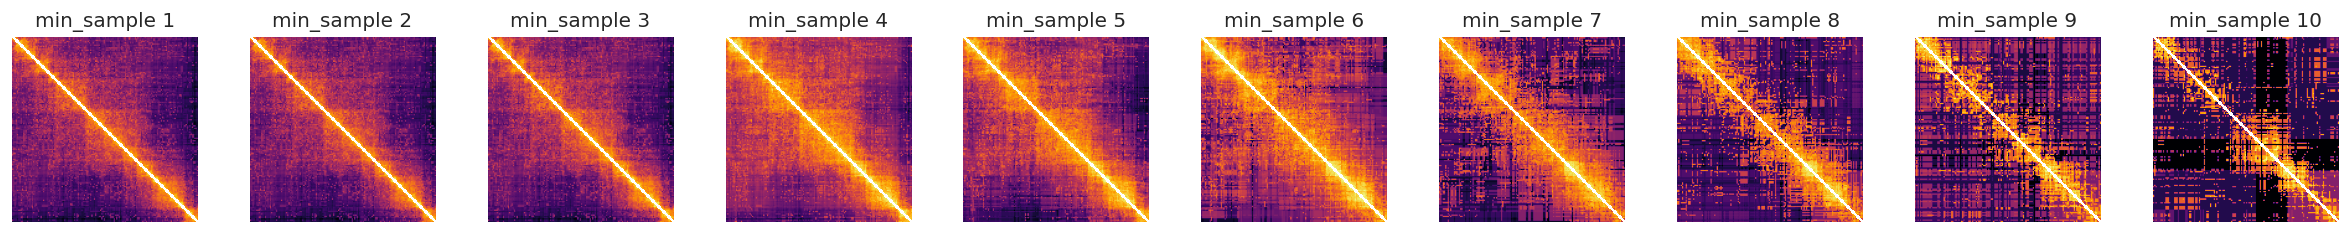

In [39]:
num_columns = len(avg_contact_matrix_list)
fig, ax = plt.subplots(1, num_columns, figsize=(num_columns * 2, 2), dpi=120)
for i, (n, img_data) in enumerate(zip(min_sample_list, avg_contact_matrix_list)):
    matrix_region = img_data[start_idx:end_idx,start_idx:end_idx]
    ax[i].imshow(np.log(matrix_region), cmap='inferno')  # 转换为密集矩阵以便绘图
    ax[i].set_title(f'min_sample {n}')
    ax[i].set_xticks([])  # 不显示刻度
    ax[i].set_yticks([])  # 不显示刻度
    ax[i].axis('off')
    
plt.tight_layout()  # 调整子图布局以适应画布
fig.subplots_adjust(hspace=0.5)

In [40]:
pcorrs_D = []
scorrs_D = []
ssmis_D = []
scc_list = []

for i in avg_contact_matrix_list:
    mat1 = i[start_idx:end_idx,start_idx:end_idx]
    mat2 = sprite_data[start_idx:end_idx,start_idx:end_idx]
    print(mat1.shape,mat2.shape)
    cor_list = mat_cor_with_na(mat1,mat2,sample=False)

    pcorrs_D.append(cor_list[0])
    scorrs_D.append(cor_list[1])
    ssmis_D.append(cor_list[2])
    scc = hicrepSCC(mat1,mat2, h, dBPMax)
    scc_list.append(scc)


slice_width_stats = pd.DataFrame({'min_list':min_sample_list,
                                 'pcorrs_D':pcorrs_D,'scorrs_D':scorrs_D, 'ssmis_D':ssmis_D,'SSC':scc_list})


(150, 150) (150, 150)
length is 22500
(150, 150) (150, 150)
length is 22500
(150, 150) (150, 150)
length is 22500
(150, 150) (150, 150)
length is 22500
(150, 150) (150, 150)
length is 22500
(150, 150) (150, 150)
length is 22500
(150, 150) (150, 150)
length is 22500
(150, 150) (150, 150)
length is 22500
(150, 150) (150, 150)
length is 22500
(150, 150) (150, 150)
length is 22500


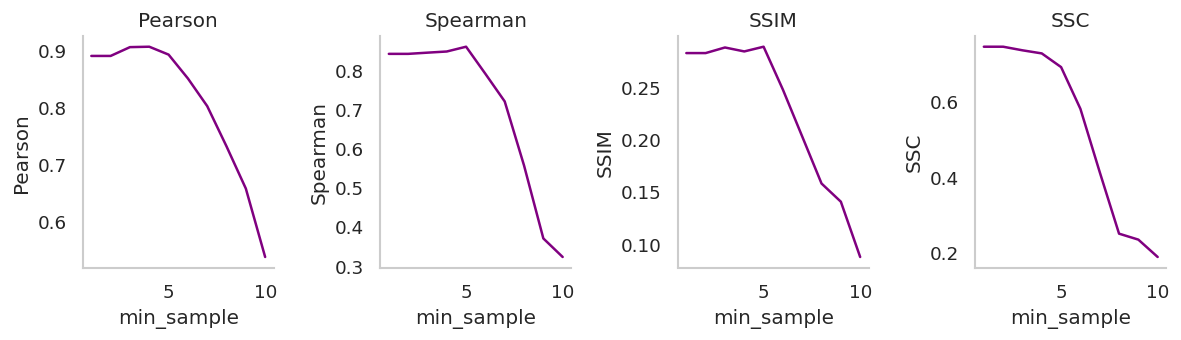

In [43]:

plot_metrics(slice_width_stats['min_list'],"min_sample"
             ,slice_width_stats['pcorrs_D']
             ,slice_width_stats['scorrs_D']
             ,slice_width_stats['ssmis_D']
             ,slice_width_stats['SSC']
             ,"","purple")

In [46]:
#dbscan
chr = "chr11(mat)"

avg_contact_matrix_list = []
cluster_size_lists = []
eps_list = np.linspace(0.3,0.7,10)
for eps in eps_list:
    print(f"eps {eps}")
    contact_matrix_list = []
    df_bin_mm9_40kb_chr = df_bin_mm9_40kb.query("chrom==@chr")
    df_bin_mm9_40kb_chr.index = range(len(df_bin_mm9_40kb_chr))
    sc_sprite_list = []
    
    cluster_size_cell = []
    for tdg_path in tdg_paths_40k2_mm9:
        
        cellname = tdg_path.split('/')[-1].split('.')[0]
        df_tdg = load_tdg(tdg_path)
        df_tdg_chr = df_tdg.query("chrom==@chr")
        df_tdg_chr.index = range(len(df_tdg_chr))
        df_tdg_chr = pd.merge(df_bin_mm9_40kb_chr[['chrom','pos']],df_tdg_chr,how='left').fillna(0)
        df_tdg_chr['bin'] = df_tdg_chr.index
        
        df_tdg_chr_result = crosslink_beads_dbscan(df_tdg_chr,eps,5)#可能会损失bin
        df_tdg_chr = pd.merge(df_tdg_chr[['chrom','pos','start','x','y','z','bin']],df_tdg_chr_result[['bin','cluster']],on="bin",how="left")
        
        contact_matrix = np.zeros((len(df_tdg_chr), len(df_tdg_chr)))
        cluster_groups = df_tdg_chr_result.groupby('cluster')
        
        cluster_size_list = []
        for cluster_id, group in cluster_groups:
            fragments = group['bin'].values
            cluster_size = len(fragments)
            cluster_size_list.append(cluster_size)
            weight = 2 / cluster_size
            for i in range(cluster_size):
                for j in range(i + 1, cluster_size):
                    bin_i = fragments[i]
                    bin_j = fragments[j]
                    contact_matrix[bin_i, bin_j] += 1*weight
                    contact_matrix[bin_j, bin_i] += 1*weight
        contact_matrix_list.append(contact_matrix)
        cluster_size_cell.append(cluster_size_list)
    avg_contact_matrix = np.mean(np.stack(contact_matrix_list),axis=0)
    avg_contact_matrix_list.append(avg_contact_matrix)
    cluster_size_lists.append(cluster_size_cell)

eps 0.3
eps 0.34444444444444444
eps 0.38888888888888884
eps 0.4333333333333333
eps 0.47777777777777775
eps 0.5222222222222221
eps 0.5666666666666667
eps 0.611111111111111
eps 0.6555555555555554
eps 0.7


/tmp/ipykernel_140790/1727166935.py:5: RuntimeWarning: divide by zero encountered in log
  ax[i].imshow(np.log(matrix_region), cmap='inferno')  # 转换为密集矩阵以便绘图


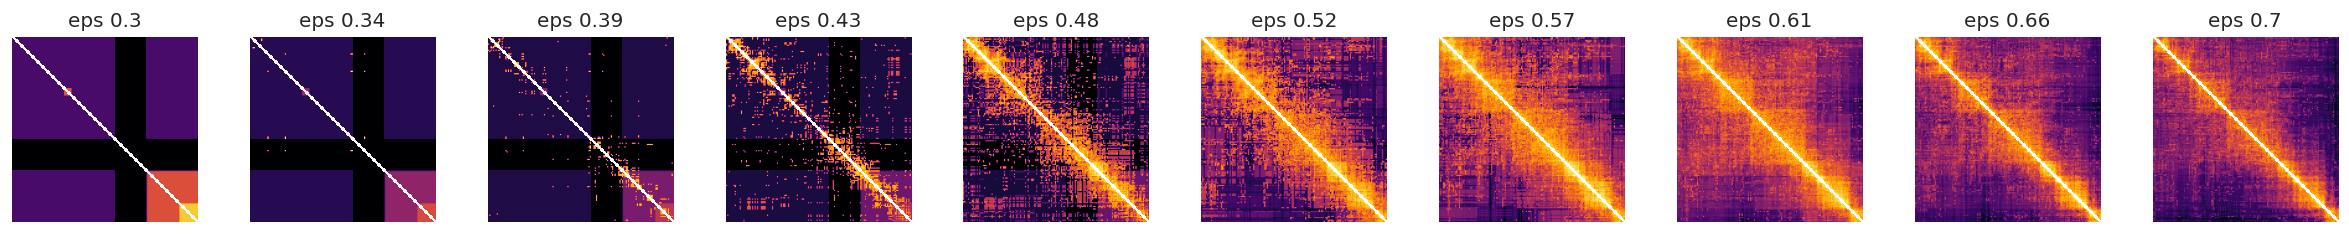

In [47]:
num_columns = len(avg_contact_matrix_list)
fig, ax = plt.subplots(1, num_columns, figsize=(num_columns * 2, 2), dpi=120)
for i, (eps, img_data) in enumerate(zip(eps_list, avg_contact_matrix_list)):
    matrix_region = img_data[start_idx:end_idx,start_idx:end_idx]
    ax[i].imshow(np.log(matrix_region), cmap='inferno')  # 转换为密集矩阵以便绘图
    ax[i].set_title(f'eps {np.round(eps,2)}')
    ax[i].set_xticks([])  # 不显示刻度
    ax[i].set_yticks([])  # 不显示刻度
    ax[i].axis('off')
    
plt.tight_layout()  # 调整子图布局以适应画布
fig.subplots_adjust(hspace=0.5)

In [52]:
pcorrs_D = []
scorrs_D = []
ssmis_D = []
scc_list = []

for i in avg_contact_matrix_list:
    mat1 = i[start_idx:end_idx,start_idx:end_idx]
    mat2 = sprite_data[start_idx:end_idx,start_idx:end_idx]
    print(mat1.shape,mat2.shape)
    cor_list = mat_cor_with_na(mat1,mat2,sample=False)

    pcorrs_D.append(cor_list[0])
    scorrs_D.append(cor_list[1])
    ssmis_D.append(cor_list[2])
    scc = hicrepSCC(mat1,mat2, h, dBPMax)
    scc_list.append(scc)


slice_width_stats = pd.DataFrame({'eps_list':eps_list,
                                 'pcorrs_D':pcorrs_D,'scorrs_D':scorrs_D, 'ssmis_D':ssmis_D,'SSC':scc_list})


(150, 150) (150, 150)
length is 22500
(150, 150) (150, 150)
length is 22500
(150, 150) (150, 150)
length is 22500
(150, 150) (150, 150)
length is 22500
(150, 150) (150, 150)
length is 22500
(150, 150) (150, 150)
length is 22500
(150, 150) (150, 150)
length is 22500
(150, 150) (150, 150)
length is 22500
(150, 150) (150, 150)
length is 22500
(150, 150) (150, 150)
length is 22500


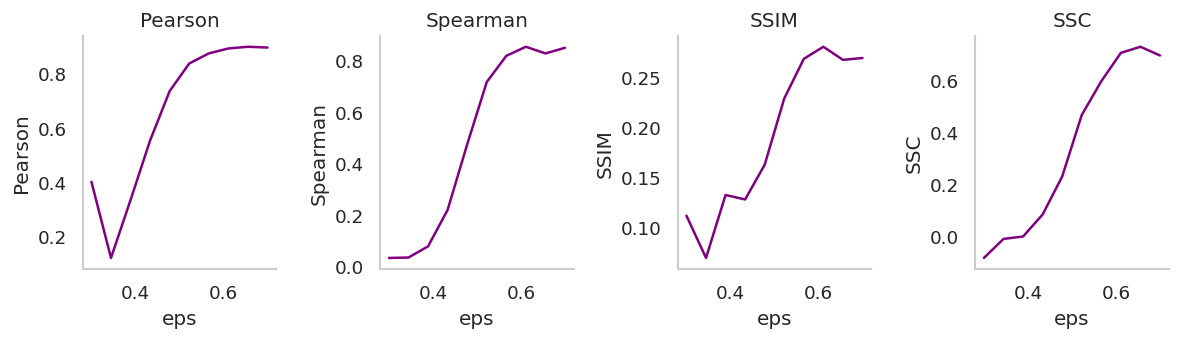

In [54]:

plot_metrics(slice_width_stats['eps_list'],"eps"
             ,slice_width_stats['pcorrs_D']
             ,slice_width_stats['scorrs_D']
             ,slice_width_stats['ssmis_D']
             ,slice_width_stats['SSC']
             ,"","purple")

In [56]:

eps = 0.55
for chr_s in chr_list:
    chr = f"{chr_s}(mat)"
    print(chr)
    cluster_dict = {}
    
    df_bin_mm9_40kb_chr = df_bin_mm9_40kb.query("chrom==@chr")
    df_bin_mm9_40kb_chr.index = range(len(df_bin_mm9_40kb_chr))

    contact_matrix_list = []
    for tdg_path in tdg_paths_40k2_mm9:
        cellname = tdg_path.split('/')[-1].split('.')[0]
        df_tdg = load_tdg(tdg_path)
        df_tdg_chr = df_tdg.query("chrom==@chr")
        #每个染色体分别处理
        df_tdg_chr.index = range(len(df_tdg_chr))
        df_tdg_chr = pd.merge(df_bin_mm9_40kb_chr[['chrom','pos']],df_tdg_chr,how='left').fillna(0)
        df_tdg_chr['bin'] = df_tdg_chr.index
        
        # df_tdg_chr = crosslink_beads(df_tdg_chr, n_clusters=n_cluster, pc=pc)#可能会损失bin
        df_tdg_chr_result = crosslink_beads_dbscan(df_tdg_chr,0.6,5)
        df_tdg_chr = df_tdg_chr[df_tdg_chr['cluster'].map(lambda _: np.random.rand() < pb)]
        
        # 将数据存储到cluster字典中
        if cellname not in cluster_dict:
            cluster_dict[cellname] = {}
        for cluster_id, group in df_tdg_chr.groupby('cluster'):
            if cluster_id not in cluster_dict[cellname]:
                cluster_dict[cellname][cluster_id] = []
            cluster_dict[cellname][cluster_id].extend(group['bin'].tolist())


        contact_matrix = np.zeros((len(df_tdg_chr), len(df_tdg_chr)))
        cluster_groups = df_tdg_chr.groupby('cluster')
        for cluster_id, group in cluster_groups:
            fragments = group['bin'].values
            cluster_size = len(fragments)
            weight = 2 / cluster_size
            for i in range(cluster_size):
                for j in range(i + 1, cluster_size):
                    bin_i = fragments[i]
                    bin_j = fragments[j]
                    contact_matrix[bin_i, bin_j] += 1*weight
                    contact_matrix[bin_j, bin_i] += 1*weight
        contact_matrix_list.append(contact_matrix)
    
    #所有细胞的平均
    avg_contact_matrix = np.mean(np.stack(contact_matrix_list),axis=0)
    np.save(f"silico_sprite_result/mESC_dbscan_{chr_s}.npy",avg_contact_matrix)

    with open(f"silico_sprite_result/mESC_dbscan_{chr_s}.pkl", 'wb') as file:
        pickle.dump(cluster_dict, file)

    

  

chr1(mat)
chr2(mat)
chr3(mat)
chr4(mat)
chr5(mat)
chr6(mat)
chr7(mat)
chr8(mat)
chr9(mat)
chr10(mat)
chr11(mat)
chr12(mat)
chr13(mat)
chr14(mat)
chr15(mat)
chr16(mat)
chr17(mat)
chr18(mat)
chr19(mat)


In [57]:
silico_sprite_data = np.load("/share/home/mliu/shareb/mliu/HiMulti/3-sprite/silico_sprite_result/mESC_dbscan_chr11.npy")

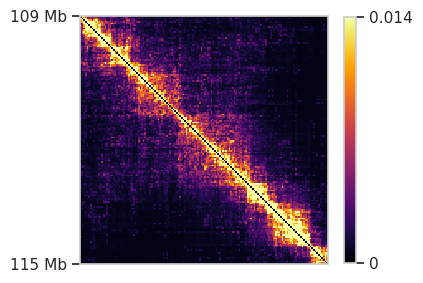

In [62]:
plot_matrix(silico_sprite_data[start_idx:end_idx,start_idx:end_idx],f"",start_pos,end_pos,"inferno",vmax=0.014,vmin=0)

In [65]:
pearsonr_value,spearmanr_value,ssmis = mat_cor_with_na(sprite_data,silico_sprite_data,sample=False) 
print(f"pearsonr_value is {pearsonr_value}\nspearmanr_value is {spearmanr_value}\nssmis is {ssmis}")


length is 9284209
pearsonr_value is 0.714403943499321
spearmanr_value is 0.4004466927371453
ssmis is 0.2596656116241185


In [64]:
pearsonr_value,spearmanr_value,ssmis = mat_cor_with_na(hic_mat,sprite_data,sample=False) 
print(f"pearsonr_value is {pearsonr_value}\nspearmanr_value is {spearmanr_value}\nssmis is {ssmis}")


length is 8702500
pearsonr_value is 0.7437939909356119
spearmanr_value is 0.3616406315274329
ssmis is 0.23131047671837598
